# Машинное обучение, ВМК МГУ

## Практическое задание 3

### Общая информация
Дата выдачи: 07.12.2017  

Мягкий дедлайн: 23:59MSK 21.12.2017 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 25.12.2017

### О задании

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI или из соревнования с платформы kaggle. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Почта: ml.cmc.msu@gmail.com

Пришлите на почту архив homework-practice-03-Username.zip с выполненным заданием. Архив должен содержать:
* Ноутбук homework-practice-03-Username.ipynb
* Модуль hw3code.py

В контест https://contest.yandex.ru/contest/6469/problems/ нужно отправить файл hw3code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

* Ссылка на посылку в Яндекс.Контесте: 10026339
* Максимальная оценка: 9.2

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.784869415354791

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.359459391563167

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1. (0.3 балла)__
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [6]:
X = np.random.exponential(size=sample_size)[:, np.newaxis]
y = f(X[:, 0]) + np.random.uniform(low=-1, high=1, size=sample_size)

In [7]:
from sklearn.tree import DecisionTreeRegressor

In [8]:
tree = DecisionTreeRegressor()
tree.fit(X, y)
X_test = linspace[:, np.newaxis]

In [9]:
y_pred = tree.predict(X_test)

In [10]:
def plot_decision_tree(X_test, y_pred, color="gray", alpha=0.5):
    #plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
    plt.plot(X_test[:, 0], y_pred, color=color, alpha=alpha) # predicted
    plt.xlabel("data", fontsize=16)
    plt.ylabel("target", fontsize=16)
    plt.title("Decision Tree Regression", fontsize=16)

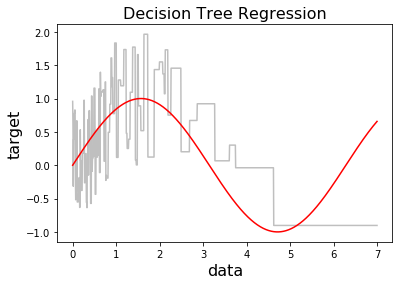

In [11]:
plt.figure()
plot_decision_tree(X_test, y_pred)
plt.plot(X_test, f(X_test), color="red") # true

Ой, переобучение

__2. (0.3 балла)__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

In [12]:
def generate_and_plot_dependencies(X_test, samples_num, max_depth=None):
    plt.figure()
    predictions = np.empty((samples_num, X_test.size))

    for i in range(samples_num):
        # Генерируем X, y
        X = np.random.exponential(size=sample_size)[:, np.newaxis]
        y = f(X[:, 0]) + np.random.uniform(low=-1, high=1, size=sample_size)
        # Обучаемся и предсказываем одни и те же точки из linspace
        tree = DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(X, y)
        predictions[i] = tree.predict(X_test)
        # Рисуем графики зависимостей
        plot_decision_tree(X_test, predictions[i])

    plt.plot(X_test, f(X_test), color="red") # true
    plot_decision_tree(X_test, np.mean(predictions, axis=0), color='black', alpha=1)
    return predictions

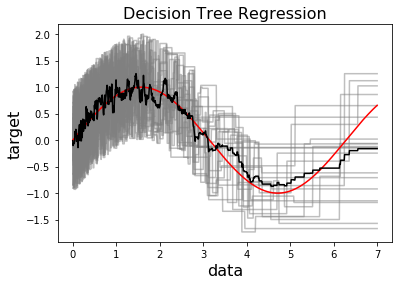

In [13]:
prediction_1 = generate_and_plot_dependencies(X_test, samples_num)
pass

Уже лучше предсказывается зависимость (хотя в областях, где данных было мало, есть серьёзные отклонения)

__3. (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика. __Избегайте копипасты кода! Сделайте функцию, параметризованную максимальной глубиной дерева, которая отрисовывает необходимые картинки!__

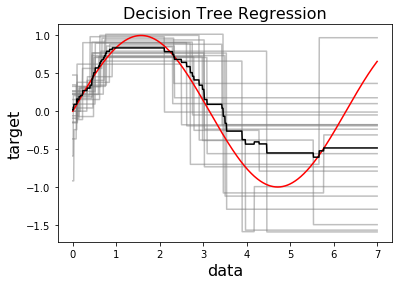

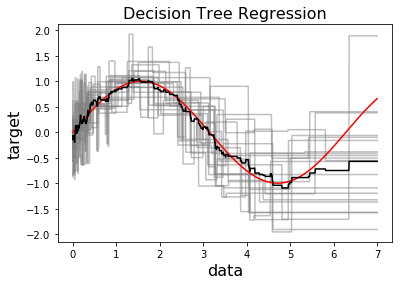

In [14]:
prediction_2 = generate_and_plot_dependencies(X_test, samples_num, max_depth=2)
prediction_3 = generate_and_plot_dependencies(X_test, samples_num, max_depth=4)
pass

В случае max_depth=4 удалось лучше аппроксимировать реальную зависимость.

В случае max_depth=2 деревья получились недообученными и не смогли хорошо восстановить реальную зависимость.

__4. (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:** Так как смещение считается как средний квадрат от ошибки композиции, то по виду кривых можно его примерно оценить. Решающие деревья хорошо подстраиваются под данные и, вообще говоря, имеют низкое смещение. Однако если ограничивать их глубину, они не успевают подстроиться под данные. Получается простая модель с большим смещением. В случае ограничения на глубину 2 это особенно хорошо видно на графике - в этом случае деревья имеют большое смещение. В случаях ограничения на глубину 4 и отсутствия ограничения можно заметить, что простое голосование даёт примерно ту же кривую, что и реальная (если закрыть глаза на то, что происходит при больших x). В этих 2 случаях смешение довольно низкое (причём в слечае ограничения на глубину 4 они ниже, чем в случае отсутствия ограничения на глубину).

#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте — это сумма истинного значения функции на объекте + шумовая компонента, также сгенерированная из некоторого распределения.

__5. (1 балл) __ 

Реализуйте функции compute_bias_variance и compute_bias_variance_fixed_samples из модуля hw3code.py

__6. (0.4 балла)__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [15]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import hw3code

In [16]:
regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              lambda size: np.random.uniform(0, 1, size=size)]

In [17]:
index = ["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"]
columns = ["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"]

df_bias = pd.DataFrame(columns=columns, index=index)
df_variance = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)

In [18]:
from importlib import reload
import hw3code

reload(hw3code)
pass

In [19]:
dependence_fun = lambda x: 5 * np.sin(10 * x)

for regressor, regr_type in zip(regressors, index):
    for generator, distr in zip(generators, columns):
        bias, variance = hw3code.compute_bias_variance(regressor, dependence_fun, x_generator=generator,
                                                       noise_generator=generator)
                                                       #sample_size=1000, samples_num=1000, objects_num=1000)
        df_bias.loc[regr_type, distr] = bias
        df_variance.loc[regr_type, distr] = variance

In [20]:
df_bias

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.3224,8.42673,10.4625,11.7002
DecisionTree,0.00526653,0.0131095,0.00126979,0.000350684
RandomForest,0.0200146,0.0444481,0.0011674,0.000316677
GradientBoosting,0.00875861,0.0175902,0.0089116,0.000978631


In [21]:
df_variance

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.0916765,0.0838604,0.0802221,0.0589324
DecisionTree,0.140549,0.257846,0.361907,0.0896784
RandomForest,0.093792,0.166162,0.19645,0.0482645
GradientBoosting,0.0839743,0.192866,0.150458,0.0392492


**Ответ:** Видим, что смщение у линейных моделей намного больше, чем у деревьев и композиций деревьев, причём у одного дерева и у композиций смещение примерно одинаковые. Разброс у линейных моделей относительно низкий. Заметно, что у одного дерева разброс в случае любого распределения больше, чем у любой линейной модели и у композиций деревьев (наибольшее значение в любом столбце находится во 2 строке).

__8. (бонус, 0.5 балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

### II. Решающие деревья своими руками

#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__9. (0.5 балла)__

Реализуйте функцию find_best_split из модуля hw3code.py

__10. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [22]:
data = pd.read_csv('students.csv')

In [23]:
data.columns

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG', ' UNS'], dtype='object')

In [57]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]]

In [77]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, X.shape[1]))

In [35]:
reload(hw3code)
pass

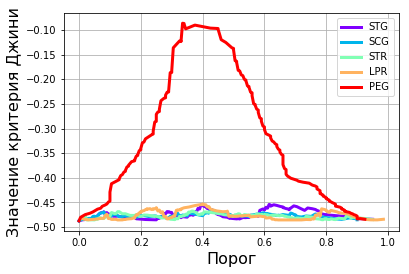

In [81]:
plt.figure()
#plt.title('Значения критерия Джини для разных признаков при разных порогах', fontsize=14)
plt.xlabel('Порог', fontsize=16)
plt.ylabel('Значение критерия Джини', fontsize=16)
for i, column in enumerate(data.columns[:-1]):
    thresholds, ginis, _, _ = hw3code.find_best_split(np.array(data[column]), np.array(data[data.columns[-1]]))
    plt.plot(thresholds, ginis, label=column, linewidth=3, c=colors[i])
plt.legend()
plt.grid()

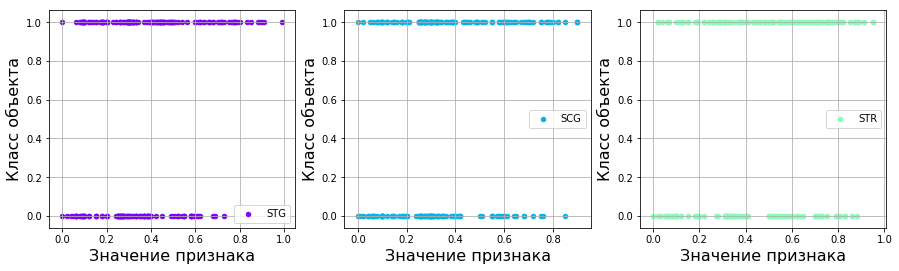

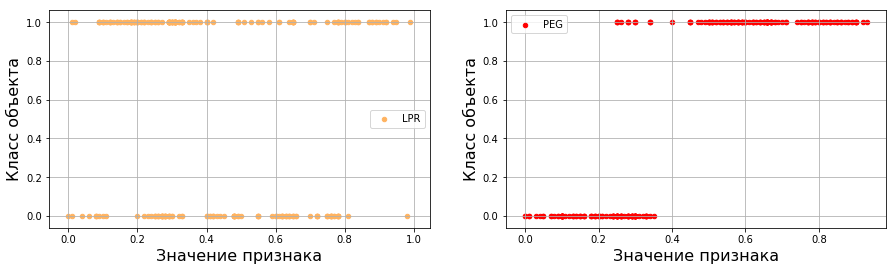

In [86]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, column in enumerate(X.columns[:3]):
    ax[i].scatter(data[column], data[data.columns[-1]], s=20, c=colors[i], label=column)
    ax[i].set_xlabel('Значение признака', fontsize=16)
    ax[i].set_ylabel('Класс объекта', fontsize=16)
    ax[i].grid()
    ax[i].legend()

_, ax = plt.subplots(1, 2, figsize=(15, 4))
for i, column in enumerate(X.columns[3:]):
    ax[i].scatter(data[column], data[data.columns[-1]], s=20, c=colors[i + 3], label=column)
    ax[i].set_xlabel('Значение признака', fontsize=16)
    ax[i].set_ylabel('Класс объекта', fontsize=16)
    ax[i].grid()
    ax[i].legend()

__11. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** На scatter-графиках видно, что только признак PEG почти идеально коррелирует с классом объекта. Остальные призаки разбросаны примерно равномерно и по ним нет смысла делать разбиение. Кривые критерия Джини подтверждают наблюдение. Похоже, что для "хороших" признаков кривая критерия Джини имеет ярко выраженный экстремум. Этот экстремум может находиться в центре, тогда его значение также должно быть существенно больше значений на краях или он может находиться на одном из краёв, тогда его значение должно быть существенно больше значения на противоположном крае. Остальные ("плохие") кривые близки к константной прямой, для них не имеет значение в какой пропорции делить.

__12. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw3code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__13. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [278]:
from sklearn import preprocessing

In [279]:
data = pd.read_csv('agaricus-lepiota.data')
data

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
5,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
6,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
7,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
8,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m
9,e,x,y,y,t,l,f,c,b,g,...,s,w,w,p,w,o,p,n,n,g


In [280]:
for column in data.columns:
    le = preprocessing.LabelEncoder()
    data[column] = le.fit_transform(data[column])

In [281]:
data

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
5,0,0,2,8,1,0,1,0,0,2,...,2,7,7,0,2,1,4,2,2,3
6,0,0,3,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,3,3
7,1,5,3,8,1,6,1,0,1,7,...,2,7,7,0,2,1,4,2,4,1
8,0,0,2,9,1,0,1,0,0,2,...,2,7,7,0,2,1,4,2,3,3
9,0,5,3,9,1,3,1,0,0,2,...,2,7,7,0,2,1,4,3,2,1


In [282]:
obj_numbers = np.arange(data.shape[0])
np.random.shuffle(obj_numbers)
train_numbers = obj_numbers[:data.shape[0] // 2]
test_numbers = obj_numbers[data.shape[0] // 2:]
X = np.array(data[data.columns[1:]])
y = np.array(data[data.columns[0]])
X_train = X[train_numbers]
X_test = X[test_numbers]
y_train = y[train_numbers]
y_test = y[test_numbers]

In [292]:
%%time
reload(hw3code)
tree = hw3code.DecisionTree(['categorical'] * X_train.shape[1])
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

split proportions =  0.526963802019 0.473036197981 current depth =  1 gini best =  -0.028255781574
split proportions =  0.985046728972 0.014953271028 current depth =  2 gini best =  -0.0249104435262
split proportions =  0.993358633776 0.00664136622391 current depth =  3 gini best =  -0.0122573939457
split proportions =  0.986150907354 0.0138490926457 current depth =  4 gini best =  -0.0102970362089
split proportions =  0.999031476998 0.000968523002421 current depth =  5 gini best =  -0.00290134374938
split proportions =  0.999515269026 0.000484730974309 current depth =  6 gini best =  -0.0019370432727
split proportions =  0.956353055286 0.0436469447139 current depth =  7 gini best =  -0.00189675611596
split proportions =  0.977777777778 0.0222222222222 current depth =  8 gini best =  -0.0
split proportions =  0.724137931034 0.275862068966 current depth =  5 gini best =  -0.0
CPU times: user 32.3 s, sys: 8.12 ms, total: 32.3 s
Wall time: 32.4 s


In [293]:
np.mean(y_pred == y_test)

1.0

__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__15. (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [320]:
from sklearn import model_selection, metrics
import sklearn

In [297]:
X_mushrooms = X
y_mushrooms = y

In [304]:
def encode_columns(data):
    for column in data.columns:
        le = preprocessing.LabelEncoder()
        data[column] = le.fit_transform(data[column])

In [305]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')

encode_columns(data)
X_tic_tac_toe = np.array(data[data.columns[1:]])
y_tic_tac_toe = np.array(data[data.columns[-1]])

In [306]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data')
mask = data[data.columns[-1]] == 'acc'
data[data.columns[-1]][mask] = 'unacc'
mask = data[data.columns[-1]] == 'good'
data[data.columns[-1]][mask] = 'vgood'

encode_columns(data)
X_cars = np.array(data[data.columns[1:]])
y_cars = np.array(data[data.columns[-1]])

In [307]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data')
mask = data[data.columns[-1]] == 'not_recom'
data[data.columns[-1]][mask] = 'recommend'
mask = data[data.columns[-1]] == 'very_recom'
data[data.columns[-1]][mask] = 'spec_prior'
mask = data[data.columns[-1]] == 'priority'
data[data.columns[-1]][mask] = 'spec_prior'

encode_columns(data)
X_nursery = np.array(data[data.columns[1:]])
y_nursery = np.array(data[data.columns[-1]])

In [327]:
index = ["DecisionTree + все признаки вещественные",
         "DecisionTree + все признаки категориальные",
         "DecisionTree + все признаки вещественные + one-hot-кодирование",
         "DecisionTreeClassifier"]
columns = ["mushrooms", "tic-tac-toe", "cars", "nursery"]

df_accuracy = pd.DataFrame(columns=columns, index=index)

In [341]:
reload(hw3code)
datasets = [(X_mushrooms, y_mushrooms), (X_tic_tac_toe, y_tic_tac_toe),
            (X_cars, y_cars), (X_nursery, y_nursery)]
for j, (X, y) in enumerate(datasets):
    estimator = hw3code.DecisionTree(['real'] * X.shape[1])
    score = model_selection.cross_val_score(estimator, X, y,
                                            scoring=metrics.make_scorer(metrics.accuracy_score),
                                            cv=10, n_jobs=-1)
    df_accuracy.loc[index[0], columns[j]] = np.mean(score)

    estimator = hw3code.DecisionTree(['categorical'] * X.shape[1])
    score = model_selection.cross_val_score(estimator, X, y,
                                            scoring=metrics.make_scorer(metrics.accuracy_score),
                                            cv=10, n_jobs=-1)
    df_accuracy.loc[index[1], columns[j]] = np.mean(score)

    encoder = preprocessing.OneHotEncoder(sparse=False)
    X = encoder.fit_transform(X)
    estimator = hw3code.DecisionTree(['real'] * X.shape[1])
    score = model_selection.cross_val_score(estimator, X, y,
                                            scoring=metrics.make_scorer(metrics.accuracy_score),
                                            cv=10, n_jobs=-1)
    df_accuracy.loc[index[2], columns[j]] = np.mean(score)

    estimator = sklearn.tree.DecisionTreeClassifier()
    score = model_selection.cross_val_score(estimator, X, y,
                                            scoring=metrics.make_scorer(metrics.accuracy_score),
                                            cv=10, n_jobs=-1)
    df_accuracy.loc[index[3], columns[j]] = np.mean(score)

In [356]:
df_accuracy

,mushrooms,tic-tac-toe,cars,nursery
DecisionTree + все признаки вещественные,0.999261,1,1,0.999923
DecisionTree + все признаки категориальные,1,1,1,0.999923
DecisionTree + все признаки вещественные + one-hot-кодирование,0.999631,1,1,0.999923
DecisionTreeClassifier,0.968389,1,1,1


__16. (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

In [376]:
data = pd.read_csv('agaricus-lepiota.data')

In [374]:
(np.array(data) == '?').any()

True

In [375]:
np.count_nonzero(np.array(data) == '?')

2480

**Ответ:** У всех алгоритмов средняя accuracy близка к 1. На разных данных алгоритмы ранжируются немного по-разному. На датасете mushrooms кодирование категориальных признаков счётчиками дало лучший результат среди всех алгоритмов. На втором месте one-hot-кодирование, и хуже всего на данном датесете было воспринимать значения признаков, как вещественные числа. На датасетах tic-tac-toe и cars все алгоритмы идеально классифицируют, а на датасете nursery sklearn-версия показала себя немнгого лучше, чем остальные алгоритмы. Более плохое качество на датасете mushrooms можно объяснить тем, что зависимость в этих данных сложнее, чем в остальных и признаков больше. Ещё можно объяснить тем, что в данных в 1 признаке есть пропуски. Всего пропущено 2480 значений. Вся информация неизвестна, и зависимость не получется восстановить точно. Неопределённость можно убрать выбрасыванием этих объектов из обучающей выборки (но это не лучшая идея) или при принятии решения, в какое из поддеревьев отправлять объект с пропуском, отправлять его одновременно в оба поддерева.

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__17. (0.5 балла)__

Загрузите датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмите из него первые 10к объектов, оставьте только вещественные признаки, а пропуски замените нулями. Разбейте выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом (если это не так, то посмотрите как ведут себя алгоритмы с разными сидами в кроссвалидации и самих алгоритмах). Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [421]:
data = pd.read_csv('train.csv').loc[0:9999]
data

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,3.575369e-02,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,5.988956e-01,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,1.345191e-02,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,2.267384e-03,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN
5,9,0,NaN,NaN,C,NaN,8.856791,NaN,NaN,0.359993,...,NaN,NaN,4.986116e-02,X,NaN,NaN,1.536222,0,NaN,NaN
6,12,0,0.899806,7.312995,C,3.494148,9.946200,1.926070,1.770427,0.066251,...,3.476299,1.992594,8.375832e-02,BJ,3.276100,1.623298,2.266575,0,2.263736,0.970873
7,21,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,BY,NaN,NaN,NaN,0,NaN,NaN
8,22,0,2.078651,8.462619,NaN,3.739030,5.265636,1.573033,2.303371,0.015869,...,8.148148,1.875560,1.865950e-02,S,1.159637,5.582865,1.105283,0,1.170731,3.333334
9,23,1,1.144802,5.880606,C,3.244469,9.538384,2.500001,1.559405,0.412610,...,7.325843,4.896617,8.943653e-03,E,1.344550,1.601176,1.928009,0,3.174603,1.000000


In [422]:
np_data = np.array(data)
mask = ((np_data == 'C') | (np_data == 'NX')).any(axis=0)
mask

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False,  True,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,

In [423]:
data.loc[:, mask]

,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,C,XDX,C,C,A,C,G,DI,C,F,B,D,E,A,E,B,O,NaN,AU
1,C,GUV,C,C,A,E,G,DY,A,F,B,D,D,B,B,A,U,G,AF
2,C,FQ,E,NaN,A,C,F,AS,A,B,B,B,E,G,C,B,S,NaN,AE
3,C,ACUE,D,C,B,C,H,BW,A,F,B,D,B,B,B,B,J,NaN,CJ
4,C,HIT,E,NaN,A,I,H,NaN,C,F,B,D,C,G,C,A,T,G,Z
5,C,AYX,A,NaN,A,I,K,DX,A,F,B,D,I,G,C,A,D,X,X
6,C,NFD,E,G,A,C,A,AS,A,F,B,D,E,B,B,B,I,NaN,BJ
7,C,AHBW,D,C,A,I,C,DP,C,F,B,D,C,A,E,A,F,M,BY
8,NaN,GKQ,E,NaN,NaN,D,H,AF,B,B,B,B,P,C,D,C,L,NaN,S
9,C,PYF,C,C,A,I,A,NaN,A,F,B,D,C,A,E,A,J,P,E


In [424]:
data = data.drop(data.columns[mask], axis=1)

In [425]:
data.fillna(0, inplace=True)
data

,ID,target,v1,v2,v4,v5,v6,v7,v8,v9,...,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,...,0.803572,8.000000,1.989780,3.575369e-02,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,0.000000,0.000000,0.000000,9.191265,0.000000,0.000000,2.301630,0.000000,...,0.000000,0.000000,0.000000,5.988956e-01,0.000000,0.000000,1.957825,0,0.000000,0.000000
2,5,1,0.943877,5.310079,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,...,2.238806,9.333333,2.477596,1.345191e-02,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,...,1.956521,7.018256,1.812795,2.267384e-03,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0,0.000000,0.000000
5,9,0,0.000000,0.000000,0.000000,8.856791,0.000000,0.000000,0.359993,0.000000,...,0.000000,0.000000,0.000000,4.986116e-02,0.000000,0.000000,1.536222,0,0.000000,0.000000
6,12,0,0.899806,7.312995,3.494148,9.946200,1.926070,1.770427,0.066251,5.011287,...,2.232558,3.476299,1.992594,8.375832e-02,3.276100,1.623298,2.266575,0,2.263736,0.970873
7,21,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0,0.000000,0.000000
8,22,0,2.078651,8.462619,3.739030,5.265636,1.573033,2.303371,0.015869,11.111111,...,1.276595,8.148148,1.875560,1.865950e-02,1.159637,5.582865,1.105283,0,1.170731,3.333334
9,23,1,1.144802,5.880606,3.244469,9.538384,2.500001,1.559405,0.412610,9.977529,...,2.715964,7.325843,4.896617,8.943653e-03,1.344550,1.601176,1.928009,0,3.174603,1.000000


In [426]:
X = np.array(data[data.columns[2:]])
y = np.array(data[data.columns[1]])

In [427]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

In [437]:
estimator = sklearn.tree.DecisionTreeClassifier()
score = model_selection.cross_val_score(estimator, X_train, y_train,
                                        scoring=metrics.make_scorer(metrics.accuracy_score),
                                        cv=3, n_jobs=-1)
np.mean(score)

0.65699892492904788

In [439]:
estimator = sklearn.ensemble.BaggingClassifier(sklearn.tree.DecisionTreeClassifier(), 100, random_state=42)
score = model_selection.cross_val_score(estimator, X, y,
                                        scoring=metrics.make_scorer(metrics.accuracy_score),
                                        cv=3, n_jobs=-1)
np.mean(score)

0.75240024024006724

In [440]:
estimator = sklearn.ensemble.RandomForestClassifier(100, random_state=42, n_jobs=-1)
score = model_selection.cross_val_score(estimator, X, y,
                                        scoring=metrics.make_scorer(metrics.accuracy_score),
                                        cv=3, n_jobs=-1)
np.mean(score)

0.75490052049614087

#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__18. (0.5 балла)__

Переберите значения от 20 до 1000-5000 деревьев с шагом 20, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [443]:
init_num_of_trees = 20
final_num_of_trees = 5000
step = 20
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=init_num_of_trees, warm_start=True,
                                                        random_state=1, n_jobs=-1)
score = []
num_of_trees = []
for cur_num in range(init_num_of_trees + step, final_num_of_trees + 2 * step, step):
    random_forest.fit(X_train, y_train)
    accuracy = np.mean(random_forest.predict(X_test) == y_test)
    score.append(accuracy)
    num_of_trees.append(random_forest.get_params()['n_estimators'])
    random_forest.set_params(n_estimators=cur_num)

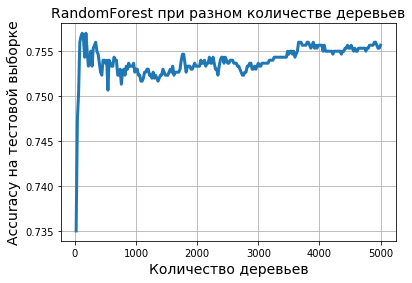

In [448]:
plt.figure()
plt.title('RandomForest при разном количестве деревьев', fontsize=14)
plt.xlabel('Количество деревьев', fontsize=14)
plt.ylabel('Accuracy на тестовой выборке', fontsize=14)
plt.plot(num_of_trees, score, linewidth=3)
plt.grid()

Как видим, случайный лес не переобучается с ростом числа деревьев, и качество выходит на ассимптоту.

#### Задача 6. Обучение градиентного бустинга

__19. (1 балл)__

А теперь попробуйте обучить на тех же данных xgboost — одну из реализаций градиентного бустинга. Подберите параметры на обучающем множестве с помощью кроссвалидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров xgboost). 

__20. (бонус, 1 балл)__

_В этом и следующем бонусе можете использовать либо теже 10к первых объектов, либо полную выборку._

Теперь вспомним, что изначально выбросили все категориальные признаки из датасета. Добавьте категориальные признаки с количеством уникальных значений < 50 тремя способами:
* как OHE признаки
* как порядковые признаки (закодируйте с помощью LabelEncoder, порядок случайный)
* как счетчики со сглаживанием

Подберите в каждом из случаев оптимальные параметры метода. Как вы думаете, должна ли меняться оптимальная глубина деревьев от способа кодирования категориальных признаков? Согласуется ли это с экспериментом? Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? 

__21. (бонус, 1 балл)__

Попробуйте пообучать на этих же данных другие реализации градиентного бустинга – catboost и lgbm. Подберите для них оптимальные параметры. Удалось ли достичь качества лучше, чем у xgboost? Сравните время обучения всех трех реализаций.

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что — простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

__22. (бонус, 0.2 балла)__ А еще, вставьте нарисованную вами смешную картинку.

In [89]:
     #
   ####
  ######
 ########
#  ~  _ #
#  O  o #
#   |   # Отвечаю, сам рисовал.
#  ͡   #
 ######

(・・ ) ?